In [1]:
# import any libraries needed
import requests
import json
import csv
import pandas as pd
import numpy as np
import re
import plotnine as p9
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Step 1: Scrape Data

In [ ]:
# Set up the API request
endpoint = "https://api.artsy.net/api/artworks"
params = {
    "size": 5000,  # Number of artworks to retrieve per page
    "page": 1,  # Page number to retrieve
}
headers = {
    "X-XAPP-Token": # Insert Token

}

# Retrieve the artworks and metadata
artworks = []
for i in range(0,1):
    response = requests.get(endpoint, params=params, headers=headers)
    data = json.loads(response.text)
    if "_embedded" in data:
        artworks += data["_embedded"]["artworks"]
    if "next" in data["_links"]:
        params["page"] += 1
    else:
        break

# Extract the metadata for each artwork
metadata = []
for artwork in artworks:
    try:
        tmp = artwork['_links']['thumbnail']['href']
    except KeyError:
        tmp = ''
    
    metadata.append({
        "id": artwork["id"],
        "title": artwork["title"],
        "medium": artwork["medium"],
        "date": artwork["date"],
        "dimensions": artwork["dimensions"]["cm"],
        "artist": artwork['_links']["artists"],
        "image_url": tmp
    })

In [ ]:
# now generate a csv of the extracted information
with open('artworks.csv', mode='w', newline='') as file:
    fieldnames = ['id', 'title', 'medium', 'date', 'text', 'height', 
                  'width', 'depth', 'diameter', 'artist', 'image_url']
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader()
    for row in metadata:
        dimensions = row.pop('dimensions')
        row.update(dimensions)

        artist_href = row['artist']['href']
        row['artist'] = artist_href

        writer.writerow(row)
# this will save our first csv file

In [ ]:
# create a data se so that we have something to refer to
df = pd.read_csv('artworks.csv')
df['artist']
# see how many events have been scraped
len(df.index)

In [ ]:
# Create empty data frame to store artwork metadata
artistdata = []
# 
# loop through data frame
for i in range(0,len(df.index)):
    #
    # add in a verbose
    if i % 100 == 0:
        print(i)
    #
    # create an empty response case
    response = requests.get(df['artist'][i], headers=headers)
    data = json.loads(response.text)
    #    
    try:
        artistdata.append({
        "name": data['_embedded']['artists'][0]['name'],
        "gender": data['_embedded']['artists'][0]['gender'],
        "birthday": data['_embedded']['artists'][0]['birthday'],
        "deathday": data['_embedded']['artists'][0]['deathday'],
        "nationality": data['_embedded']['artists'][0]['nationality']
        })
    except (KeyError, IndexError):
        artistdata.append({
        "name": ' ',
        "gender": ' ',
        "birthday": ' ',
        "deathday": ' ',
        "nationality": ' '
    })

In [ ]:
# make a data set of artists
with open('artists.csv', mode='w', newline='') as file:
    fieldnames = ['name', 'gender', 'birthday', 'deathday', 'nationality']
    writer = csv.DictWriter(file, fieldnames = fieldnames)

    writer.writeheader()
    for artist in artistdata:
        writer.writerow(artist)

In [ ]:
# turn the artists into a data frame 
df2 = pd.read_csv('artists.csv')

In [ ]:
# concatenate the two data frames by adding columns
cdf = pd.concat([df, df2], axis=1)

In [ ]:
# save the data frame as a CSV file
cdf.to_csv('artsy.csv', index=False)

# Step 2: Clean Data Frames

In [2]:
# Load data
artsy = pd.read_csv('artsy.csv')

In [3]:
# Look at variables in data
artsy.columns.values

array(['ID', 'Title', 'Medium', 'Date', 'text', 'Height (cm)',
       'Width (cm)', 'Depth (cm)', 'Diameter (cm)', 'Artist', 'URL',
       'Name', 'Gender', 'BeginDate', 'EndDate', 'Nationality '],
      dtype=object)

In [4]:
# Remove any rows with missing information
artsy = artsy.dropna(subset=['Gender'])

In [5]:
# Note that in doing this we have binned any of the noisy or poorly formatted data
len(artsy)

2554

In [6]:
# Create a new DataFrame with only the specified columns in the desired order
artsy = artsy[['Title', 'Name', 'Gender', 'Nationality ', 'Date']]
artsy = artsy.tail(-1)
#
artsy.head()

,Title,Name,Gender,Nationality,Date
1,The Third of May,Pierre-Michel Alix after Jean-François Garnere...,male,NaN,1814
2,The Company of Frans Banning Cocq and Willem v...,John Jones after Thomas Beach,male,NaN,1642
4,Luncheon on the Grass (Le Déjeuner sur l'herbe),Hans Baldung,male,German,1863
5,The Birth of Venus,Geraud Vidal after P. Davesne,male,NaN,ca. 1486
6,The Birth of Venus,"Hans Weiditz, II and Ulrich von Hutten (author)",male,NaN,1863


In [7]:
# load moma data frame 
moma = pd.read_csv('moma.csv')

/var/folders/m4/h2pgj21s5fqffvzv_vrgl3_80000gn/T/ipykernel_7186/3887148998.py:2: DtypeWarning: Columns (30,31,32,33,36) have mixed types. Specify dtype option on import or set low_memory=False.


In [8]:
# Reduce data frame to necessary info
moma = moma[['Title', 'Artist', 'Gender', 'Nationality', 'Date']]
#
moma.head()

,Title,Artist,Gender,Nationality,Date
0,"Ferdinandsbrücke Project, Vienna, Austria (Ele...",Otto Wagner,(Male),(Austrian),1896
1,"City of Music, National Superior Conservatory ...",Christian de Portzamparc,(Male),(French),1987
2,"Villa near Vienna Project, Outside Vienna, Aus...",Emil Hoppe,(Male),(Austrian),1903
3,"The Manhattan Transcripts Project, New York, N...",Bernard Tschumi,(Male),(),1980
4,"Villa, project, outside Vienna, Austria, Exter...",Emil Hoppe,(Male),(Austrian),1903


In [9]:
# define a function for stripping out years
def extract_year(date):
    # Check if date is string
    if isinstance(date, str):
        # remove whitespace
        date = date.strip()  
        #
        # If date is an approximation (contains 'ca.' or 'c.')
        if 'ca.' in date or 'c.' in date:
            # Strip non-digit characters and convert to int
            try:
                return int(re.sub(r'\D', '', date))
            except ValueError:
                return None
        #
        # If date is a range
        if '-' in date:
            start = date.split('-')[0]  # only take the first part before '-'
            # split on '.' and take the part before the decimal point
            try:
                return int(start.strip().split('.')[0])
            except ValueError:
                return None
        #
        # If date is a single year
        try:
            # split on '.' and take the part before the decimal point
            return int(date.split('.')[0])
        except ValueError:
            return None
    else:
        # If the date is not a string convert it directly to an int
        try:
            return int(date)
        except (ValueError, TypeError):
            return None

In [10]:
# Removing 'ca. ' in 'Date' then convert to numeric
artsy['Date'] = artsy['Date'].str.replace('ca. ', '')
artsy['Date'] = pd.to_numeric(artsy['Date'], errors='coerce')

# Removing brackets in moma
moma['Gender'] = moma['Gender'].str.replace(r'\(|\)', '')
moma['Nationality'] = moma['Nationality'].str.replace(r'\(|\)', '')
moma['Date'] = moma['Date'].apply(extract_year)

# Rename in moma to match artsy
artsy = artsy.rename(columns={'Title': 'Artwork', 'Name': 'Artist', 'Gender': 'Gender',
                             'Nationality ': 'Nationality', 'Date': 'Date'})
moma = moma.rename(columns={'Title': 'Artwork', 'Artist': 'Artist', 'Gender': 'Gender',
                             'Nationality': 'Nationality', 'Date': 'Date'})

/var/folders/m4/h2pgj21s5fqffvzv_vrgl3_80000gn/T/ipykernel_7186/2561243742.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
/var/folders/m4/h2pgj21s5fqffvzv_vrgl3_80000gn/T/ipykernel_7186/2561243742.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
/var/folders/m4/h2pgj21s5fqffvzv_vrgl3_80000gn/T/ipykernel_7186/2561243742.py:7: FutureWarning: The default value of regex will change from True to False in a future version.


In [11]:
# merge the data frames
df = pd.concat([artsy, moma], ignore_index=True)
df.head()

,Artwork,Artist,Gender,Nationality,Date
0,The Third of May,Pierre-Michel Alix after Jean-François Garnere...,male,NaN,1814.0
1,The Company of Frans Banning Cocq and Willem v...,John Jones after Thomas Beach,male,NaN,1642.0
2,Luncheon on the Grass (Le Déjeuner sur l'herbe),Hans Baldung,male,German,1863.0
3,The Birth of Venus,Geraud Vidal after P. Davesne,male,NaN,1486.0
4,The Birth of Venus,"Hans Weiditz, II and Ulrich von Hutten (author)",male,NaN,1863.0


In [12]:
# Now we can make some plots
# Make sure date is integers
df = df.dropna(subset=['Date'])
df['Date'] = df['Date'].astype(int)

In [13]:
# clean up the gender column
def decide_gender(gender):
    # deal with any strings first
    if isinstance(gender, str):
        # Convert to lowercase and split the string into words
        words = gender.lower().split()
        # create counts
        male_count = words.count('male')
        female_count = words.count('female')
        #
        # decide where to send it
        if male_count > female_count:
            return 'Male'
        elif female_count > male_count:
            return 'Female'
        else:
            return 'Other'
    else:
        return 'Other'

df['Gender'] = df['Gender'].apply(decide_gender)

In [14]:
# clean up the year column and add century column
def year_to_century(year):
    if pd.isnull(year):
        return np.nan
    else:
        return year // 100 + 1 if year % 100 != 0 else year // 100

df['Century'] = df['Date'].apply(year_to_century)

In [15]:
# remove any rows with issues
df = df[df['Century'] <= 21]

In [16]:
# Summarise this data in a meaningful way
summary_df = df.groupby(['Century', 'Gender']).size().reset_index(name='Count')
summary_df.head()

,Century,Gender,Count
0,2,Male,2
1,4,Male,1
2,6,Other,1
3,8,Male,1
4,12,Male,2


 # Step 3: Generate Plots

/opt/homebrew/lib/python3.10/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


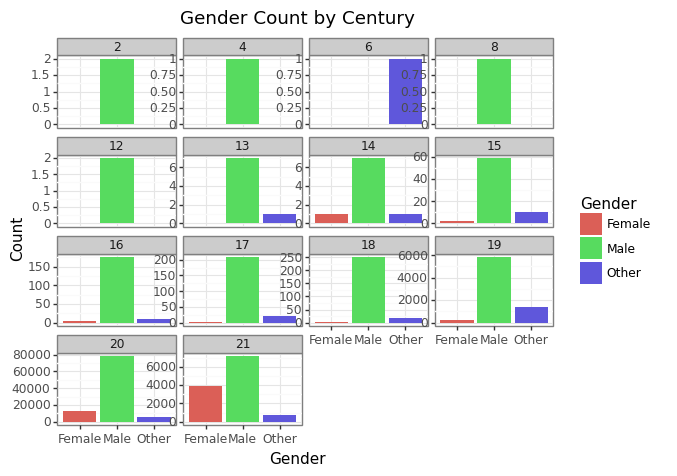

<ggplot: (392297301)>

In [17]:
# Create the plot of gender in each century
(p9.ggplot(summary_df, p9.aes(x='Gender', y='Count', fill='Gender')) 
 + p9.geom_bar(stat='identity', position='dodge') 
 + p9.facet_wrap('~Century', scales='free_y') 
 + p9.theme_bw() 
 + p9.labs(title='Gender Count by Century', x='Gender', y='Count')
)

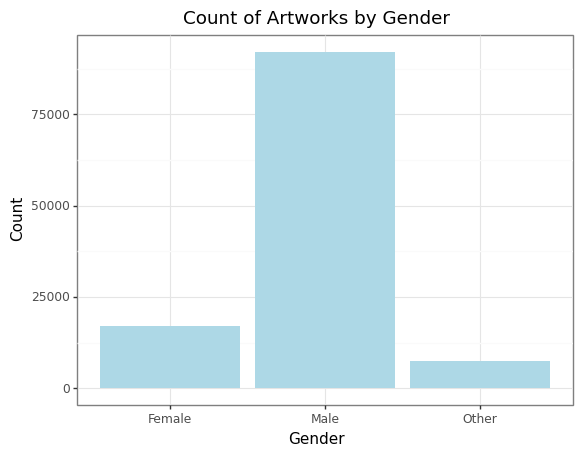

In [18]:
# Replace empty strings with NaN
df['Nationality'] = df['Nationality'].replace(' ', np.nan)
# Fill NaNs in 'Nationality' column
df['Nationality'] = df['Nationality'].fillna('Unknown')


# Now, let's start with some basic EDA
# Count of Artworks by Gender
gender_artwork_count = (
    p9.ggplot(df, p9.aes(x='Gender')) +
    p9.geom_bar(fill='lightblue') +
    p9.theme_bw() +
    p9.labs(title='Count of Artworks by Gender', x='Gender', y='Count')
)

print(gender_artwork_count)

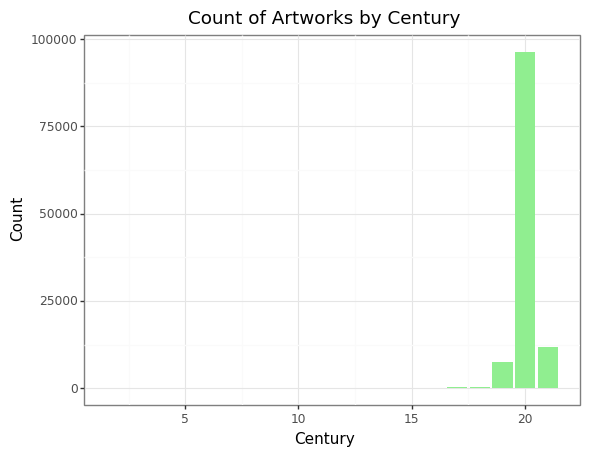

In [19]:
# Count of Artworks by Century
century_artwork_count = (
    p9.ggplot(df, p9.aes(x='Century')) +
    p9.geom_bar(fill='lightgreen') +
    p9.theme_bw() +
    p9.labs(title='Count of Artworks by Century', x='Century', y='Count')
)

print(century_artwork_count)

In [20]:
# have a look at the unique factors to define a dictionary
df['Nationality'] = df['Nationality'].apply(lambda x: x.split()[0] if x.strip() != "" else 'Unknown')
df['Nationality'].unique()

array(['Unknown', 'German', 'Italian', 'American', 'French', 'Spanish',
       'Swiss', 'Dutch', 'Czech', 'Flemish', 'German-American', 'South',
       'British', 'English', 'Belgian', 'Scottish', 'Swiss-German',
       'Netherlandish', 'Swedish', 'Austrian', 'Danish', 'Japanese',
       'Argentine', 'Brazilian', 'Luxembourger', 'Iranian', 'Finnish',
       'Canadian', 'Nationality', 'Russian', 'Moroccan', 'Colombian',
       'Australian', 'Slovenian', 'Hungarian', 'Chilean', 'Mexican',
       'Latvian', 'Polish', 'Greek', 'Israeli', 'Czechoslovakian',
       'Croatian', 'Norwegian', 'Georgian', 'Ukrainian', 'Yugoslav',
       'Cuban', 'Romanian', 'Venezuelan', 'Thai', 'Icelandic', 'Serbian',
       'Guatemalan', 'Uruguayan', 'Indian', 'Chinese', 'Costa',
       'Ethiopian', 'Kuwaiti', 'Haitian', 'Zimbabwean', 'Ecuadorian',
       'Portuguese', 'Peruvian', 'Azerbaijani', 'Native', 'Malian',
       'Irish', 'Cambodian', 'Korean', 'Estonian', 'Pakistani',
       'Bulgarian', 'Bolivian', 

In [21]:
# We now need a dictionary to map countries to nationality
nationality_to_country = {
    'Unknown': 'Unknown',
    'German': 'Germany',
    'Italian': 'Italy',
    'American': 'United States',
    'French': 'France',
    'Spanish': 'Spain',
    'Swiss': 'Switzerland',
    'Dutch': 'Netherlands',
    'Czech': 'Czech Republic',
    'Flemish': 'Belgium',
    'German-American': 'United States',
    'South': 'Venezuela',
    'British': 'United Kingdom',
    'English': 'United Kingdom',
    'Belgian': 'Belgium',
    'Scottish': 'United Kingdom',
    'Swiss-German': 'Switzerland',
    'Netherlandish': 'Netherlands',
    'Swedish': 'Sweden',
    'Austrian': 'Austria',
    'Danish': 'Denmark',
    'Japanese': 'Japan',
    'Argentine': 'Argentina',
    'Brazilian': 'Brazil',
    'Luxembourger': 'Luxembourg',
    'Iranian': 'Iran',
    'Finnish': 'Finland',
    'Canadian': 'Canada',
    'Nationality': 'Unknown',
    'Russian': 'Russia',
    'Moroccan': 'Morocco',
    'Colombian': 'Colombia',
    'Australian': 'Australia',
    'Slovenian': 'Slovenia',
    'Hungarian': 'Hungary',
    'Chilean': 'Chile',
    'Mexican': 'Mexico',
    'Latvian': 'Latvia',
    'Polish': 'Poland',
    'Greek': 'Greece',
    'Israeli': 'Israel',
    'Czechoslovakian': 'Czech Republic', 
    'Croatian': 'Croatia',
    'Norwegian': 'Norway',
    'Georgian': 'Georgia',
    'Ukrainian': 'Ukraine',
    'Yugoslav': 'Croatia',  
    'Cuban': 'Cuba',
    'Romanian': 'Romania',
    'Venezuelan': 'Venezuela',
    'Thai': 'Thailand',
    'Icelandic': 'Iceland',
    'Serbian': 'Serbia',
    'Guatemalan': 'Guatemala',
    'Uruguayan': 'Uruguay',
    'Indian': 'India',
    'Chinese': 'China',
    'Costa': 'Costa Rica', 
    'Ethiopian': 'Ethiopia',
    'Kuwaiti': 'Kuwait',
    'Haitian': 'Haiti',
    'Zimbabwean': 'Zimbabwe',
    'Ecuadorian': 'Ecuador',
    'Portuguese': 'Portugal',
    'Peruvian': 'Peru',
    'Azerbaijani': 'Azerbaijan',
    'Native': 'American',  
    'Malian': 'Mali',
    'Irish': 'Ireland',
    'Cambodian': 'Cambodia',
    'Korean': 'South Korea', 
    'Estonian': 'Estonia',
    'Pakistani': 'Pakistan',
    'Bulgarian': 'Bulgaria',
    'Bolivian': 'Bolivia',
    'Panamanian': 'Panama',
    'Turkish': 'Turkey',
    'Taiwanese': 'Taiwan',
    'Paraguayan': 'Paraguay',
    'Nicaraguan': 'Nicaragua',
    'Tunisian': 'Tunisia',
    'Sudanese': 'Sudan',
    'Tanzanian': 'Tanzania',
    'Senegalese': 'Senegal',
    'Bahamian': 'Bahamas',
    'Congolese': 'Democratic Republic of the Congo', 
    'Puerto': 'Puerto Rico',
    'New': 'New Zealand',  # This term is too vague
    'Lebanese': 'Lebanon',
    'Kenyan': 'Kenya',
    'Nigerian': 'Nigeria',
    'Egyptian': 'Egypt',
    'Albanian': 'Albania',
    'Namibian': 'Namibia',
    'Bosnian': 'Bosnia and Herzegovina',
    'Slovak': 'Slovakia',
    'Ghanaian': 'Ghana',
    'Afghan': 'Afghanistan',
    'Kyrgyz': 'Kyrgyzstan',
    'Lithuanian': 'Lithuania',
    'Ugandan': 'Uganda',
    'Cameroonian': 'Cameroon',
    'Welsh': 'United Kingdom',
    'Malaysian': 'Malaysia',
    'Vietnamese': 'Vietnam',
    'Algerian': 'Algeria',
    'Palestinian': 'Palestine',
    'Macedonian': 'North Macedonia',
    'Filipino': 'Philippines',
    'Bangladeshi': 'Bangladesh',
    'Burkinabé': 'Burkina Faso',
    'Beninese': 'Benin',
    'Sierra': 'Sierra Leone',
    'Ivorian': 'Ivory Coast',
    'Emirati': 'United Arab Emirates',
    'Singaporean': 'Singapore',
    'Salvadoran': 'El Salvador',
    'Iraqi': 'Iraq',
    'Mozambican': 'Mozambique'
}

In [22]:
# Use the dictionary to create country
df['Country'] = df['Nationality'].map(nationality_to_country)

# Fill NaN values with unknown
df['Country'] = df['Country'].fillna('Unknown')

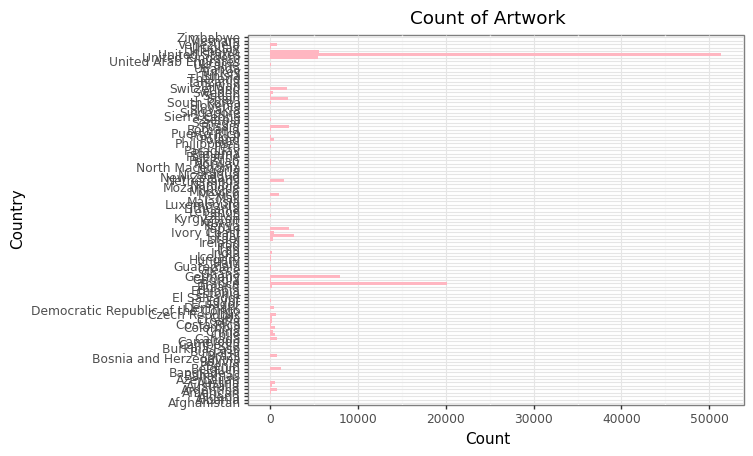

In [23]:
# Count of Artworks by Nationality
nationality_artwork_count = (
    p9.ggplot(df, p9.aes(x='Country')) +
    p9.geom_bar(fill='lightpink') +
    p9.theme_bw() +
    p9.labs(title='Count of Artwork', x='Country', y='Count') +
    p9.coord_flip()
)

print(nationality_artwork_count)

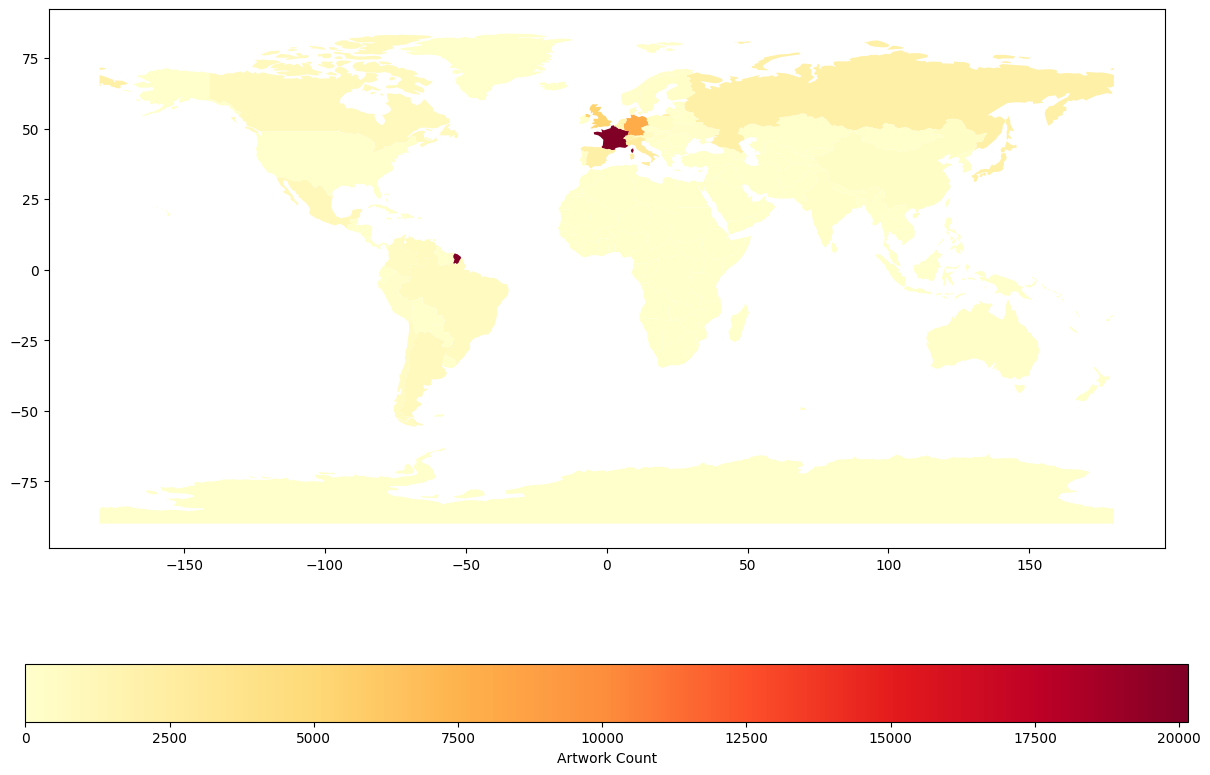

In [24]:
# Now to produce a world map by intensity

# get the shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#
# Aggregate the data by country
df_agg = df.groupby('Country').size().reset_index(name='counts')
#
# Merge with the world dataframe
world_df = world.merge(df_agg, left_on='name', right_on='Country', how='left')
#
# Fill NaN values with zero
world_df['counts'] = world_df['counts'].fillna(0)
#
# Create a figure and axes
fig, ax = plt.subplots(figsize=(15,10))
#
# Create the map
world_df.plot(column='counts', 
              ax=ax, 
              legend=True, 
              cmap='YlOrRd', 
              legend_kwds={'label': "Artwork Count", 
                           'orientation': "horizontal"},
              missing_kwds={'color': 'lightgrey'})
#
plt.show()

In [25]:
# Lets also perform some k-means clustering to see what factors effect 
# gender of art
#
# Select only numeric columns
df_numeric = df.select_dtypes(include=[np.number])
#
# Normalise the data
x = df_numeric.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalised = pd.DataFrame(x_scaled, columns = df_numeric.columns)

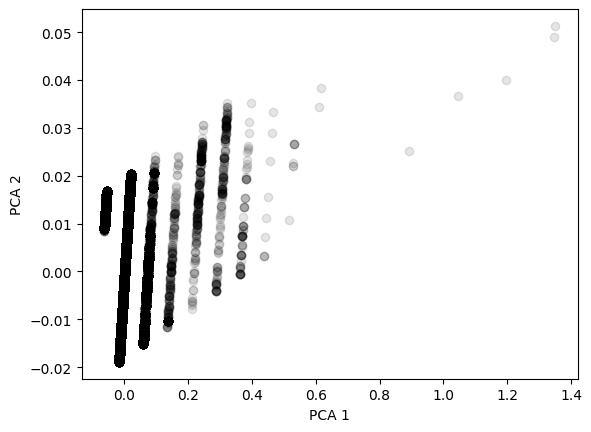

In [26]:
# Apply PCA and fit the features
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_normalised)
#
# Create a DataFrame with the two components
PCA_components = pd.DataFrame(principalComponents, columns=['PC1', 'PC2'])

# Plot the components to see our new data frame
plt.scatter(PCA_components['PC1'], PCA_components['PC2'], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

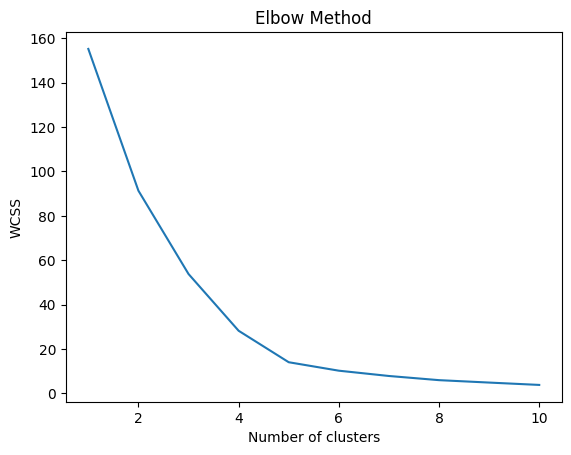

In [27]:
# Calculate the within-cluster sum of squares for different numbers of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=200, n_init=15, random_state=0)
    kmeans.fit(PCA_components)
    wcss.append(kmeans.inertia_)

# Plot the results
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


# The elbow point in this method clearly shows as we would expect
# that 2 or 3 clusters is appropriate for Gender. Most of our data
# falls into male or female with only a small percentage being other

In [28]:
# Create a kmeans classifier with 2 as agreed by elbow point
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=200, n_init=15, random_state=0)
#
# Fit the data
clusters = kmeans.fit_predict(PCA_components)
#
# Add the cluster column to the PCA_components dataframe
PCA_components['Cluster'] = clusters

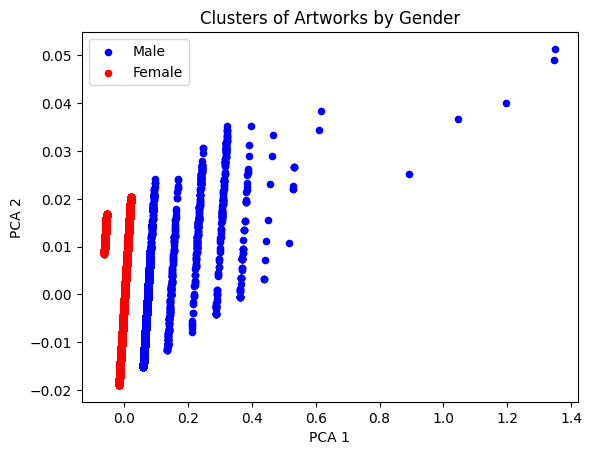

In [29]:
# Plot the clusters
plt.scatter(PCA_components[PCA_components['Cluster'] == 0]['PC1'], 
            PCA_components[PCA_components['Cluster'] == 0]['PC2'], 
            s = 20, c = 'blue', label = 'Male')
plt.scatter(PCA_components[PCA_components['Cluster'] == 1]['PC1'], 
            PCA_components[PCA_components['Cluster'] == 1]['PC2'], 
            s = 20, c = 'red', label = 'Female')
#
plt.title('Clusters of Artworks by Gender')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

# This is our estimation

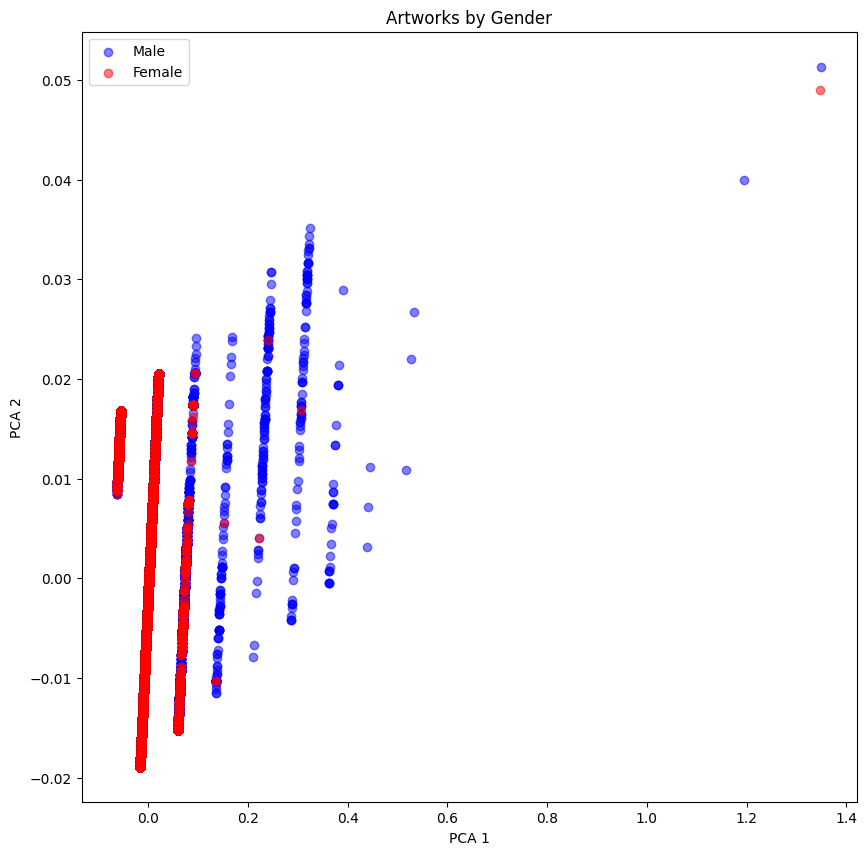

In [30]:
# compare back to original results
gender_mapping = {"Male": 0, "Female": 1}
df['GenderNumeric'] = df['Gender'].map(gender_mapping)

PCA_components['Gender'] = df['GenderNumeric']
plt.figure(figsize=(10, 10))

for gender, color in zip(('Male', 'Female'), ('blue', 'red')):
    plt.scatter(PCA_components[PCA_components['Gender'] == gender_mapping[gender]]['PC1'], 
                PCA_components[PCA_components['Gender'] == gender_mapping[gender]]['PC2'], 
                color=color, alpha=0.5, label=gender)

plt.title('Artworks by Gender')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()